In [1]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [3]:
import os 
import sys
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from sklearn import model_selection
from __future__ import absolute_import
# os.chdir("/content/drive/Hamming")
# sys.path.append("Hamming")

/home/anton/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# !pip install hyperopt
# !pip install networkx==1.11

In [5]:
TRAIN_PATH = './dataset_files/hamming_small.txt'  # "/content/drive/Hamming/dataset_files/hamming.txt"

COLUMN_NAMES = ['plainword', 'codeword', 
                'id_error', 'bin_error', 'defective_codeword']
def load_data():
    return pd.read_csv(TRAIN_PATH, sep=';', names=COLUMN_NAMES)

In [6]:
def make_features():
#     data['dec_defective_codeword'] = data['defective_codeword'][:].apply(lambda x: int(x, 2))

    for j in range(len(data['codeword'][0])):
        data['cod_' + str(j)] = data['codeword'][:].apply(lambda x: int(x[j]))

    for j in range(len(data['defective_codeword'][0])):
        data['def_' + str(j)] = data['defective_codeword'][:].apply(lambda x: int(x[j]))

#     for j in range(len(data['bin_error'][0])):
#         data['mask_' + str(j)] = data['bin_error'][:].apply(lambda x: int(x[j]))
        
    data['weight'] = 1
    data.loc[data['codeword'] == data['defective_codeword'], 'weight'] = 19
    for j in range(len(data['plainword'][0])):
        data['pln_' + str(j)] = data['plainword'][:].apply(lambda x: int(x[j]))
    
#     return data

In [7]:
def split_data(test_size): 
    train_data, test_data, train_labels, test_labels = \
        model_selection.train_test_split(data.loc[:, 'def_0':'weight'], 
                                         data.loc[:, 'cod_0':'cod_30'], # 'mask_0':'pln_25' 
                                         test_size = test_size) 
    
    train_weight = train_data.pop('weight')
    test_data.drop(columns=['weight'], inplace=True)
    return np.array(train_data), np.array(test_data), np.array(train_labels), np.array(test_labels), np.array(train_weight)

In [8]:
%%time
data = load_data()
print(data.shape)
make_features()
print(data.shape)
train_data, test_data, train_labels, test_labels, train_weight = split_data(test_size=0.3)

(65536, 5)
(65536, 94)
CPU times: user 2.55 s, sys: 108 ms, total: 2.66 s
Wall time: 2.66 s


In [9]:
def probs_to_labels(predicted_probs):
    return [1 if x > 0.5 else 0 for x in predicted_probs]
def count_errors(y, y_pred):
  count = 0
  for i in range (0,31):
    labelBit = y[i]
    resultBit = y_pred[i]
    if labelBit != resultBit:
      count += 1
  return count

In [10]:
# errorStats = {'0': 0}
# for i in range(0, y_pred.shape[0]):
#   resultArray = probs_to_labels(y_pred[i])
#   errorNum = count_errors(test_labels[i], resultArray)
#   if errorStats.get(str(errorNum)) == None:
#     errorStats[str(errorNum)] = 0
#   errorStats[str(errorNum)] += 1
# print(errorStats)
def binary_accuracy(y, y_pred):
    return sum(int(np.array_equal(a, probs_to_labels(b))) for (a,b) in zip(y, y_pred)) / y.shape[0]


In [39]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

X = train_data
y = train_labels
X_val = test_data
y_val = test_labels
activations = ['relu', 'tanh', 'softmax', 'elu']
space = {'choice': hp.choice('num_layers',
                    [ {'layers':'three', },
                    {'layers':'four',
                      'units4': hp.choice('units4_4', [128, 256, 512, 1024]), 
                      'activation4': hp.choice('activation4_4', activations),
                      'dropout4': 1},#hp.choice('dropout4', [.75, 1])}
                    { 'layers': 'five', 
                      'units4': hp.choice('units5_4', [128, 256, 512, 1024]), 
                      'activation4': hp.choice('activation5_4', activations),
                      'dropout4': 1,
                      'units5': hp.choice('units5_5', [128, 256, 512, 1024]), 
                      'activation5': hp.choice('activation5_5', activations),
                      'dropout5': 1
                     }
                    ]),

            'units1': hp.choice('units1', [128, 256, 512, 1024]),
            'units2': hp.choice('units2', [128, 256, 512, 1024]),
            'units3': hp.choice('units3', [128, 256, 512, 1024]), 

            'dropout1': 1,#hp.choice('dropout1', [.75, 1]),
            'dropout2': 1,#hp.choice('dropout2', [.75, 1]),
            'dropout3': 1,#hp.choice('dropout3', [.75, 1]),
         
            'activation1': hp.choice('activation1', activations),
            'activation2': hp.choice('activation2', activations),
            'activation3': hp.choice('activation3', activations),

            'batch_size' : hp.choice('batch_size', [32, 64, 128]),

            'nb_epochs' :  hp.choice('nb_epochs', [5, 7, 10]),
            'optimizer': hp.choice('optimizer', ['adadelta','adam','rmsprop']),
            #'activation': hp.choice('activation', ['sigmoid', 'tanh']),
            'last_activation': hp.choice('last_activation', ['sigmoid', 'hard_sigmoid'])
        }

In [40]:
scores = []
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta, Adam, rmsprop
import json


In [41]:
from keras.callbacks import History 
history = History()

In [42]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [43]:
scores_file = 'scores_test.json'

In [44]:
X.shape

(45875, 31)

In [45]:
def f_nn(params):   
    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(units=int(params['units1']), input_dim = X.shape[1])) 
    model.add(Activation(params['activation1']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(units=int(params['units2']), kernel_initializer = "glorot_uniform")) 
    model.add(Activation(params['activation2']))
    model.add(Dropout(params['dropout2']))

    model.add(Dense(units=int(params['units3']), kernel_initializer = "glorot_uniform"))
    model.add(Activation(params['activation3']))
    model.add(Dropout(params['dropout3']))

    if params['choice']['layers'] == 'four':
        model.add(Dense(units=int(params['choice']['units4']), kernel_initializer = "glorot_uniform")) 
        model.add(Activation(params['choice']['activation4']))
        model.add(Dropout(params['choice']['dropout4']))  
        
    if params['choice']['layers'] == 'five':
        model.add(Dense(units=int(params['choice']['units4']), kernel_initializer = "glorot_uniform")) 
        model.add(Activation(params['choice']['activation4']))
        model.add(Dropout(params['choice']['dropout4']))  
        model.add(Dense(units=int(params['choice']['units5']), kernel_initializer = "glorot_uniform")) 
        model.add(Activation(params['choice']['activation5']))
        model.add(Dropout(params['choice']['dropout5']))
        
    model.add(Dense(31))
    model.add(Activation(params['last_activation']))
#     from keras.utils import plot_model
#     plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    model.compile(loss='binary_crossentropy', metrics = ['binary_accuracy'], optimizer=params['optimizer'])
   
    model.fit(X, y, 
              epochs=params['nb_epochs'],
              batch_size=int(params['batch_size']),
              sample_weight = train_weight,
              callbacks=[history,
#                          early_stopping],
                        ],
              verbose = 0)

    pred_auc = model.predict(X_val)
#     acc = roc_auc_score(y_val, pred_auc)
    acc = binary_accuracy(y_val, pred_auc)
    print('ACCURACY:', acc)
    testing_params = params
    testing_params['accuracy'] = acc
    jsonResult = testing_params
    file = open(scores_file, 'a')
    json.dump(testing_params, file, indent = 4)
    file.write(',\n')
    file.close()
    sys.stdout.flush() 
    scores.append((acc, params))
    return {'loss': -acc, 'status': STATUS_OK}

In [46]:
trials = Trials()
file = open(scores_file, 'w')
file.write('[\n')
file.close()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=1, trials=trials) ## replace max_evals back to 350
print('best: ')
print(best)
file = open(scores_file, 'a')
file.write(']\n')
file.close()

Params testing:  {'activation1': 'elu', 'activation2': 'relu', 'activation3': 'tanh', 'batch_size': 64, 'choice': {'activation4': 'relu', 'activation5': 'tanh', 'dropout4': 1, 'dropout5': 1, 'layers': 'five', 'units4': 128, 'units5': 128}, 'dropout1': 1, 'dropout2': 1, 'dropout3': 1, 'last_activation': 'sigmoid', 'nb_epochs': 5, 'optimizer': 'rmsprop', 'units1': 128, 'units2': 256, 'units3': 1024}
ACCURACY: 0.11459234016581049
best: 
{'activation1': 3, 'activation2': 0, 'activation3': 1, 'activation5_4': 0, 'activation5_5': 1, 'batch_size': 1, 'last_activation': 0, 'nb_epochs': 0, 'num_layers': 2, 'optimizer': 2, 'units1': 0, 'units2': 1, 'units3': 3, 'units5_4': 0, 'units5_5': 0}


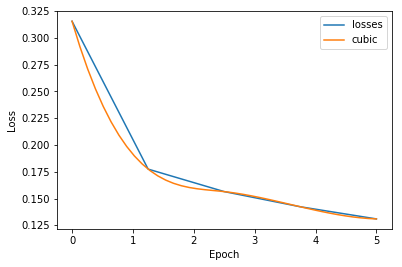

In [47]:
from scipy.interpolate import interp1d

y = history.history['loss']
x = np.linspace(0, len(y), num=len(y), endpoint=True)
f = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, len(y), num=40, endpoint=True)

plt.plot(x, y, '-', xnew, f(xnew))
plt.legend(['losses', 'cubic'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [48]:
print(max(scores))

(0.11459234016581049, {'activation1': 'elu', 'activation2': 'relu', 'activation3': 'tanh', 'batch_size': 64, 'choice': {'activation4': 'relu', 'activation5': 'tanh', 'dropout4': 1, 'dropout5': 1, 'layers': 'five', 'units4': 128, 'units5': 128}, 'dropout1': 1, 'dropout2': 1, 'dropout3': 1, 'last_activation': 'sigmoid', 'nb_epochs': 5, 'optimizer': 'rmsprop', 'units1': 128, 'units2': 256, 'units3': 1024, 'accuracy': 0.11459234016581049})
